# Homework 3: Aerial/Satellite Imagery Retrieval

In [1]:
import json
import urllib

import numpy as np
from IPython.display import Image

In [2]:
key ='AjuHD4_2U47VT5_T-TXs4rUzGHTCIWkZPNZc1_QAuFaG352qQrBJCk2oM_GvOme2'

In [3]:
# reference: https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
EARTH_RADIUS = 6378137
# constraints of Mercator projection used by Bing map
MIN_LAT = -85.05112878
MAX_LAT = 85.05112878  
MIN_LON = -180
MAX_LON = 180 
        
def map_size(level_of_detail):
    '''map_size = map width = map height'''
    return 256 << level_of_detail

def clip(n, min_val, max_val):
    return min(max(n, min_val), max_val)

def ground_resolution(lat, level):
    lat = clip(lat, MIN_LAT, MAX_LAT)
    return (np.cos(lat * np.pi/180) * 2 * np.pi * EARTH_RADIUS) / map_size(level)

def lat_long_to_tile_x_y(lat, lon, level):
    lat = clip(lat, MIN_LAT, MAX_LAT)
    lon = clip(lon, MIN_LON, MAX_LON)
    sin_lat = np.sin(lat * np.pi / 180)
    x = (lon + 180) / 360 # shift from [-180, 180] to [0, 360] and then normalize
    y = 0.5 - np.log((1+sin_lat) / (1-sin_lat)) / (4*np.pi)
    pixel_x = clip(x * map_size(level) + 0.5, 0, map_size(level) - 1)
    pixel_y = clip(y * map_size(level) + 0.5, 0, map_size(level) - 1)
    tile_x = np.floor(pixel_x / 256)
    tile_y = np.floor(pixel_y / 256)
    return int(tile_x), int(tile_y)

def tile_x_y_to_quadkey(tile_x, tile_y, level):
    quadkey = []
    tile_x_reversed = [char for char in bin(tile_x).replace("0b","").zfill(level)][::-1]
    tile_y_reversed = [char for char in bin(tile_y).replace("0b","").zfill(level)][::-1]
    for i in range(len(tile_x_reversed)):
        quadkey.append(tile_x_reversed[i])
        quadkey.append(tile_y_reversed[i])
    num = int(''.join(quadkey[::-1]), 2)
    return number_to_base(num, 4).zfill(level)

def number_to_base(n, b):
    if n == 0:
        return '0'
    digits = []
    while n:
        digits.append(str(n % b))
        n //= b
    return ''.join(digits[::-1])

def lat_lon_to_quadkey(lat, lon, level):
    tile_x, tile_y = lat_long_to_tile_x_y(lat, lon, level)
    return tile_x_y_to_quadkey(tile_x, tile_y, level)

In [4]:
# visualization test
level = 3
tile = 2**level
for i in range(tile):
    row = [tile_x_y_to_quadkey(j, i, level).zfill(level) for j in range(tile)]
    print(row)

['000', '001', '010', '011', '100', '101', '110', '111']
['002', '003', '012', '013', '102', '103', '112', '113']
['020', '021', '030', '031', '120', '121', '130', '131']
['022', '023', '032', '033', '122', '123', '132', '133']
['200', '201', '210', '211', '300', '301', '310', '311']
['202', '203', '212', '213', '302', '303', '312', '313']
['220', '221', '230', '231', '320', '321', '330', '331']
['222', '223', '232', '233', '322', '323', '332', '333']


In [5]:
def find_max_level(lat_1, lon_1, lat_2, lon_2):
    for level in range(1, 23):
        quadkey_1 = lat_lon_to_quadkey(lat_1, lon_1, level)
        quadkey_2 = lat_lon_to_quadkey(lat_2, lon_2, level)
        if quadkey_1 != quadkey_2:
            break
        highest_quadkey = quadkey_1
        highest_level = level
    return highest_quadkey, highest_level

In [15]:
# reference: https://docs.microsoft.com/en-us/bingmaps/rest-services/directly-accessing-the-bing-maps-tiles
def retrieve_satellite_image_from_quadkey(lat_1, lon_1, lat_2, lon_2, verbose=False):
    metadata_url = 'http://dev.virtualearth.net/REST/V1/Imagery/Metadata/Aerial?output=json&include=ImageryProviders&key={BingMapsKey}'.format(BingMapsKey=key)
    request = urllib.request.Request(metadata_url)
    response = urllib.request.urlopen(request)
    metadata = json.loads(response.read())
    if verbose: print(metadata)
    # request from fetched metadata
    highest_quadkey, highest_level = find_max_level(lat_1, lon_1, lat_2, lon_2)
    request_url = metadata['resourceSets'][0]['resources'][0]['imageUrl'].format(subdomain='t0', quadkey=highest_quadkey)
    request = urllib.request.Request(request_url)
    response = urllib.request.urlopen(request)
    return response.read(), highest_quadkey, highest_level

## Test

level of detail: 12
quadkey: 120220011012
ground resolution (meters/pixel) 25.1450099326402


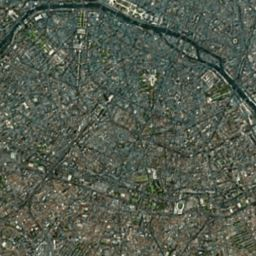

In [16]:
lat_1 = 48.8580 # coordinates of Eiffel Tower
lon_1 = 2.2945

lat_2 = 48.8530 # coordinates of Cathédrale Notre-Dame de Paris
lon_2 = 2.3499

img, quadkey, level = retrieve_satellite_image_from_quadkey(lat_1, lon_1, lat_2, lon_2)

print('level of detail:', level)
print('quadkey:', quadkey)
print('ground resolution (meters/pixel)', ground_resolution(lat_1, level))

# show image 
Image(img)

In [8]:
# save image
with open('image.jpeg', 'wb') as file:
    file.write(img)

# Alternative One-shot Method

In [9]:
# reference: https://docs.microsoft.com/en-us/bingmaps/rest-services/imagery/get-a-static-map
MAX_WIDTH = 2000 # maximum possible
MAX_HEIGHT = 1500 # maximum possible

In [10]:
# bounding box format: South Latitude, West Longitude, North Latitude, East Longitude
# https://docs.microsoft.com/en-us/bingmaps/rest-services/common-parameters-and-types/location-and-area-types
def encode_coordinates(lat1, lon1, lat2, lon2):
    south_lat = min(lat1, lat2)
    west_lon = min(lon1, lon2)
    north_lat = max(lat1, lat2)
    east_lon = max(lon1, lon2)
    return ','.join(list(map(str, [south_lat, west_lon, north_lat, east_lon])))

In [11]:
def retrieve_satellite_image(lat1, lon1, lat2, lon2):
    mapSize = '{},{}'.format(MAX_WIDTH, MAX_HEIGHT)
    coordinates = encode_coordinates(lat1, lon1, lat2, lon2)
    request_url = "https://dev.virtualearth.net/REST/v1/Imagery/Map/{imagerySet}?mapArea={mapArea}&mapSize={mapSize}&format={format}&mapMetadata={mapMetadata}&key={BingMapsAPIKey}".format(imagerySet='Aerial', mapArea=coordinates, mapSize=mapSize, format='jpeg', mapMetadata=0, BingMapsAPIKey=key)
    request = urllib.request.Request(request_url)
    response = urllib.request.urlopen(request)
    return response.read()

## Test

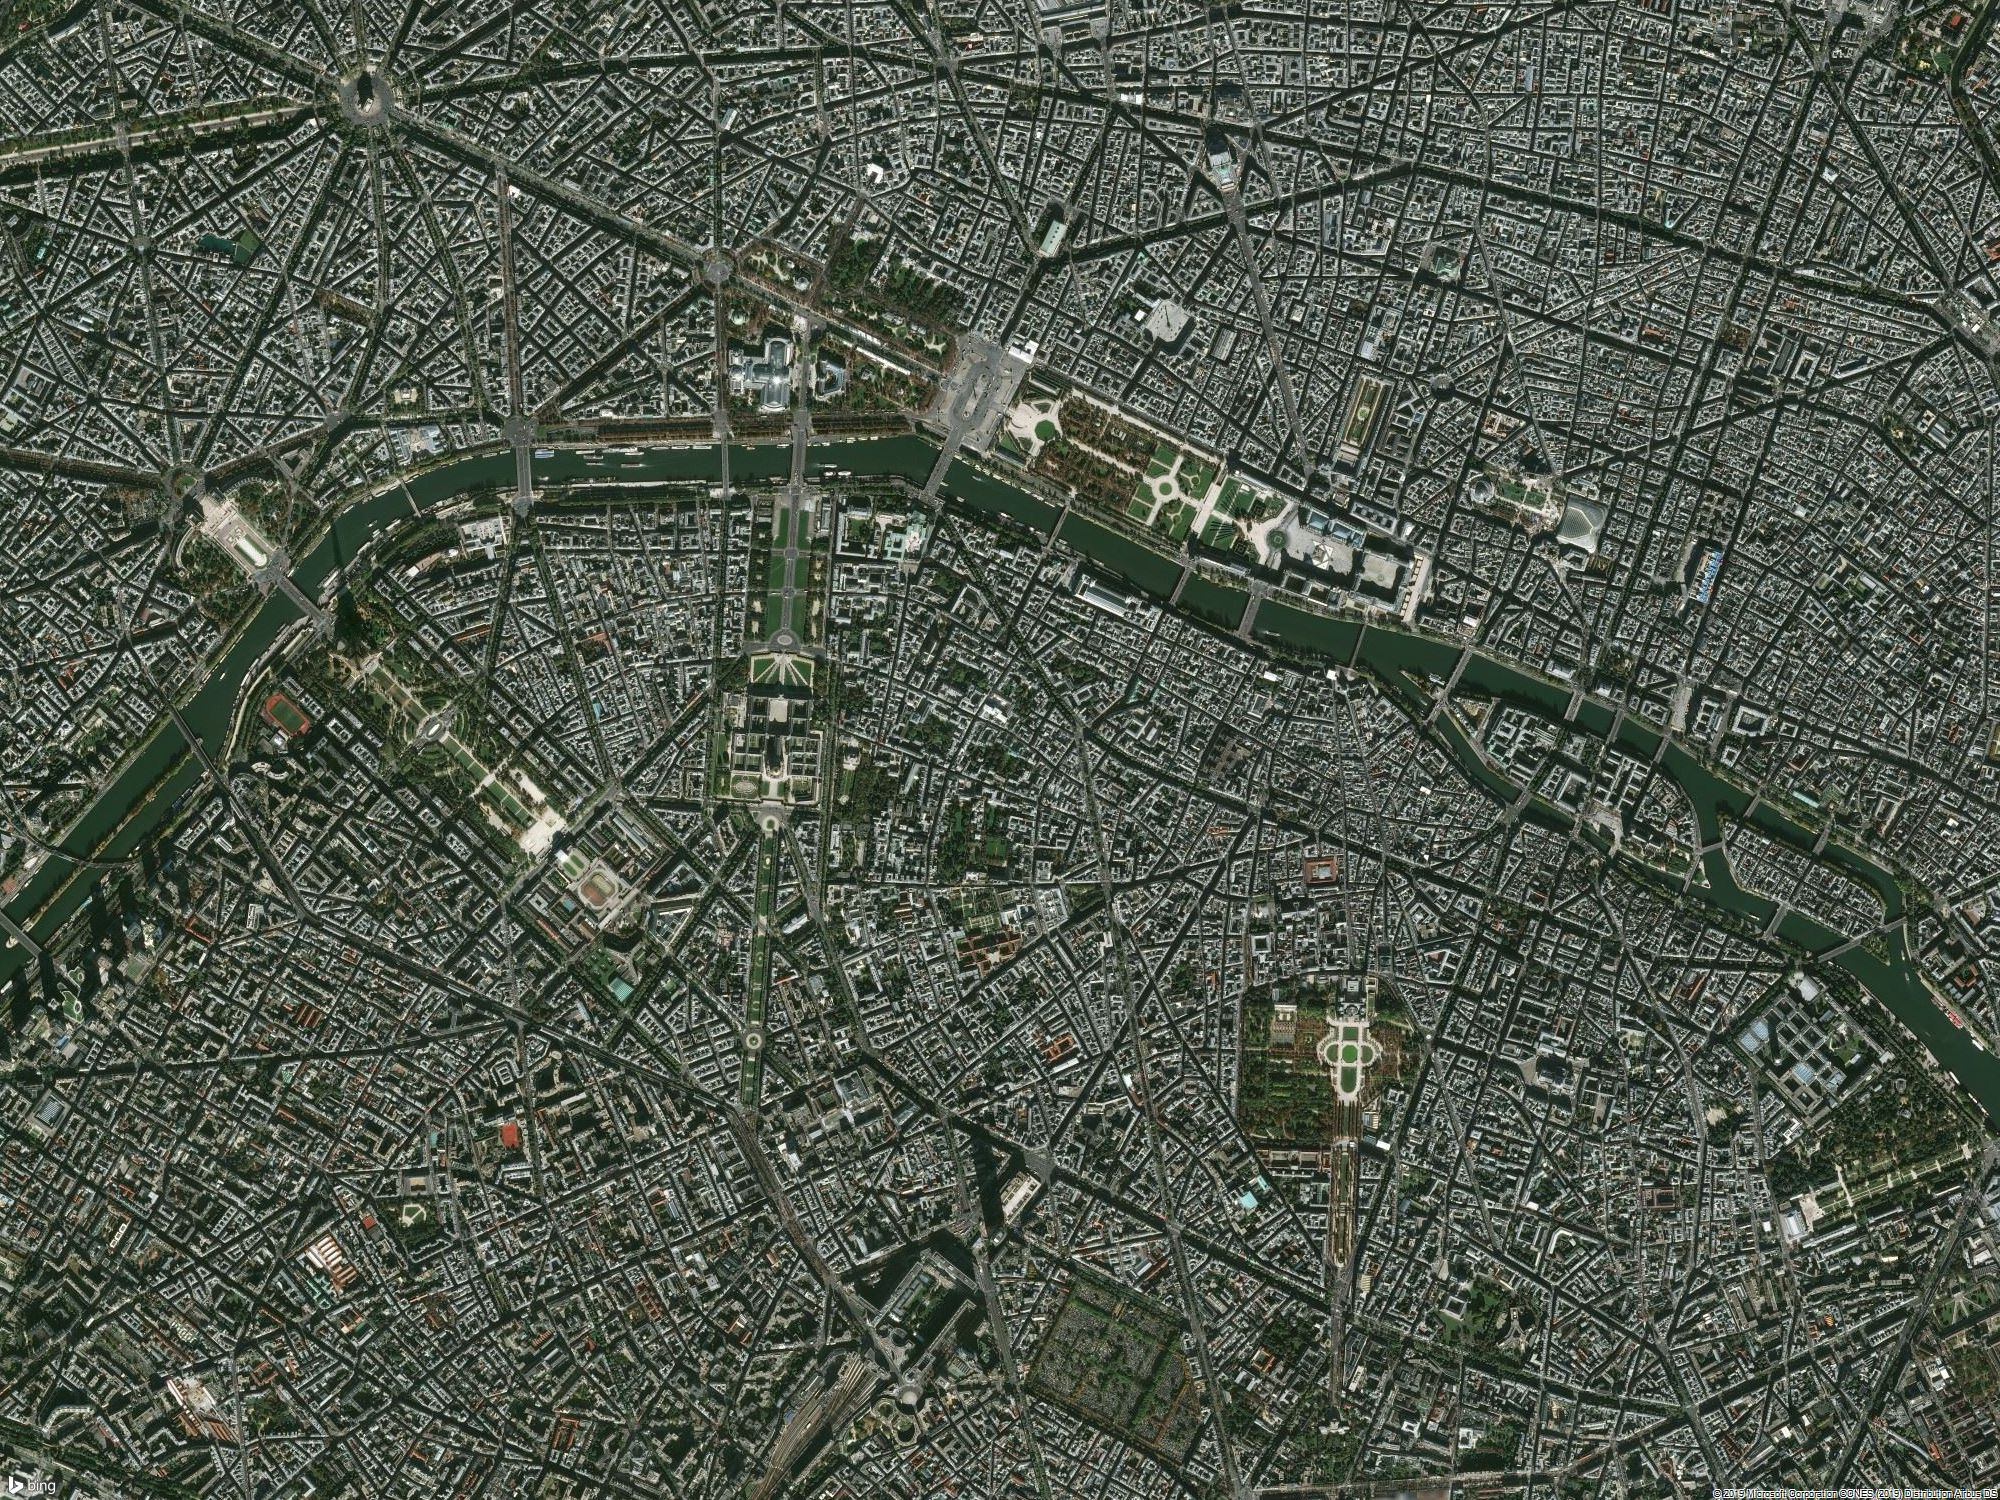

In [14]:
lat_1 = 48.8580
lon_1 = 2.2945
lat_2 = 48.8530
lon_2 = 2.3499

img = retrieve_satellite_image(lat_1, lon_1, lat_2, lon_2)

# show image 
Image(img)

In [13]:
# save image
with open('image.jpeg', 'wb') as file:
    file.write(img)